In [2]:
# import numpy as np
import pandas as pd
import lightgbm as lgb
import os
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm
import json 
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from itertools import product
import ast
import numpy as np

### 多分类feature

In [3]:
path = 'data2/'
train_queries1 = pd.read_csv(path + 'train_queries_phase1.csv', parse_dates=['req_time'])
train_queries2 = pd.read_csv(path + 'train_queries_phase2.csv', parse_dates=['req_time'])
train_plans1   = pd.read_csv(path + 'train_plans_phase1.csv', parse_dates=['plan_time'])
train_plans2   = pd.read_csv(path + 'train_plans_phase2.csv', parse_dates=['plan_time'])
train_clicks1  = pd.read_csv(path + 'train_clicks_phase1.csv')
train_clicks2  = pd.read_csv(path + 'train_clicks_phase2.csv')
profiles      = pd.read_csv(path + 'profiles.csv') 
test_queries  = pd.read_csv(path + 'test_queries.csv', parse_dates=['req_time'])
test_plans    = pd.read_csv(path + 'test_plans.csv', parse_dates=['plan_time'])

In [4]:
train_queries = train_queries1.append(train_queries2)
train_plans = train_plans1.append(train_plans2)
train_clicks = train_clicks1.append(train_clicks2)

In [5]:
#base data
train = train_queries.merge(train_plans, 'left', ['sid'])
test  = test_queries.merge(test_plans, 'left', ['sid'])
train = train.merge(train_clicks, 'left', ['sid'])
train['click_mode'] = train['click_mode'].fillna(0).astype(int)
data  = pd.concat([train, test], ignore_index=True)
data  = data.merge(profiles, 'left', ['pid']) 
data.shape

(2304916, 75)

In [6]:
#od feature
from gen_feature import get_haversine_np
data['o_lng'] = data['o'].apply(lambda x: float(x.split(',')[0]))
data['o_lat'] = data['o'].apply(lambda x: float(x.split(',')[1]))
data['d_lng'] = data['d'].apply(lambda x: float(x.split(',')[0]))
data['d_lat'] = data['d'].apply(lambda x: float(x.split(',')[1])) 
data['haversine'] = data.apply(lambda x:get_haversine_np(x['o_lat'],
                                                        x['o_lng'],
                                                        x['d_lat'],
                                                        x['d_lng']),axis=1)
od_feature = ['o_lng','o_lat','d_lng','d_lat','haversine']
data.shape

(2304916, 80)

In [7]:
time_feature = []
data['req_time_day'] = data['req_time'].apply(lambda x :x.day)
data['req_time_hour'] = data['req_time'].apply(lambda x :x.hour)
data['req_time_weekday'] = data['req_time'].apply(lambda x :x.dayofweek+1)
data['time_diff'] = data['plan_time'].astype(int) - data['req_time'].astype(int)
time_feature.extend(['req_time_day','req_time_hour','req_time_weekday','time_diff'])
data.shape

(2304916, 84)

In [8]:
profile_feature    = ['p' + str(i) for i in range(66)]
data['p_sum'] = data[profile_feature].apply(lambda x:x.sum(),axis=1)
data.shape

(2304916, 85)

In [9]:
from gen_feature import gen_plan_feas
data['plans_json'] = data['plans'].fillna('[]').apply(lambda x: json.loads(x))
data_plans = gen_plan_feas(data)
plan_features = [col for col in data_plans.columns if col not in ['sid']]
data = data.merge(data_plans, on='sid', how='left')
data.shape

2304916it [12:45, 3011.34it/s]


mode tfidf...


(2304916, 127)

In [10]:
# data.to_csv('data2/feature_base.csv',index=None)

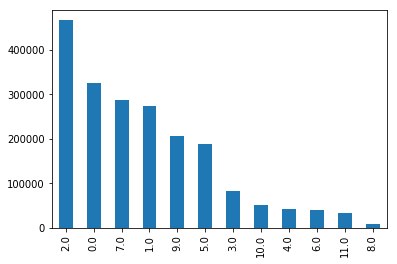

In [12]:
# data['click_mode'].value_counts().plot('bar')

## 多分类

In [14]:
def f1_weighted(labels,preds):
    preds = np.argmax(preds.reshape(12, -1), axis=0)
    score = f1_score(y_true=labels, y_pred=preds, average='weighted')
    return 'f1_weighted', score, True

### baseline

In [15]:
profile_features = profile_feature+['p_sum']
origin_num_feature = od_feature + profile_features
cate_feature       = ['pid']
feature            = origin_num_feature + cate_feature + plan_features + time_feature
print(len(feature), feature)

118 ['o_lng', 'o_lat', 'd_lng', 'd_lat', 'haversine', 'p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'p_sum', 'pid', 'mode_feas_0', 'mode_feas_1', 'mode_feas_2', 'mode_feas_3', 'mode_feas_4', 'mode_feas_5', 'mode_feas_6', 'mode_feas_7', 'mode_feas_8', 'mode_feas_9', 'mode_feas_10', 'mode_feas_11', 'max_dist', 'min_dist', 'mean_dist', 'std_dist', 'max_price', 'min_price', 'mean_price', 'std_price', 'max_eta', 'min_eta', 'mean_eta', 'std_eta', 'max_dist_mode', 'min_dist_mode', 'max_price_mode', 'min_price_mode', 'max_eta_mode', 'min_eta_mode', 'first_mode', 'svd_mode_0', 'svd_mode_1', 'svd_

In [14]:
train_index = (data.req_time < '2018-11-23')
train_x     = data[train_index][feature].reset_index(drop=True)
train_y     = data[train_index].click_mode.reset_index(drop=True)

valid_index = (data.req_time > '2018-11-23') & (data.req_time < '2018-12-01')
valid_x     = data[valid_index][feature].reset_index(drop=True)
valid_y     = data[valid_index].click_mode.reset_index(drop=True)

test_index = (data.req_time > '2018-12-01')
test_x     = data[test_index][feature].reset_index(drop=True)
train_x.shape,valid_x.shape,test_x.shape

((1742557, 118), (257443, 118), (304916, 118))

In [15]:
lgb_model = lgb.LGBMClassifier(boosting_type="gbdt", num_leaves=61, reg_alpha=0, reg_lambda=0.01,
    max_depth=-1, n_estimators=2000, objective='multiclass',importance_type='gain',
    subsample=0.8, colsample_bytree=0.8, subsample_freq=1,min_child_samples = 200, 
                               learning_rate=0.05, random_state=2019, metric="None",n_jobs=-1)
eval_set = [(valid_x, valid_y)]
lgb_model.fit(train_x, train_y, eval_set=eval_set, eval_metric=f1_weighted,categorical_feature=cate_feature, 
              verbose=10, early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds.
[10]	valid_0's f1_weighted: 0.638157
[20]	valid_0's f1_weighted: 0.667079
[30]	valid_0's f1_weighted: 0.669827
[40]	valid_0's f1_weighted: 0.670632
[50]	valid_0's f1_weighted: 0.671768
[60]	valid_0's f1_weighted: 0.672278
[70]	valid_0's f1_weighted: 0.67265
[80]	valid_0's f1_weighted: 0.673112
[90]	valid_0's f1_weighted: 0.673461
[100]	valid_0's f1_weighted: 0.673547
[110]	valid_0's f1_weighted: 0.673977
[120]	valid_0's f1_weighted: 0.67395
[130]	valid_0's f1_weighted: 0.674117
[140]	valid_0's f1_weighted: 0.67426
[150]	valid_0's f1_weighted: 0.674257
[160]	valid_0's f1_weighted: 0.674252
[170]	valid_0's f1_weighted: 0.674263
[180]	valid_0's f1_weighted: 0.674253
[190]	valid_0's f1_weighted: 0.674233
[200]	valid_0's f1_weighted: 0.674196
[210]	valid_0's f1_weighted: 0.674138
[220]	valid_0's f1_weighted: 0.674201
[230]	valid_0's f1_weighted: 0.674238
[240]	valid_0's f1_weighted: 0.674193
[250]	valid_0's f1_weighted: 0.674105

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
        importance_type='gain', learning_rate=0.05, max_depth=-1,
        metric='None', min_child_samples=200, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=2000, n_jobs=-1, num_leaves=61,
        objective='multiclass', random_state=2019, reg_alpha=0,
        reg_lambda=0.01, silent=True, subsample=0.8,
        subsample_for_bin=200000, subsample_freq=1)

In [15]:
#过拟合
# lgb_model = lgb.LGBMClassifier(boosting_type="gbdt", num_leaves=80, reg_alpha=0, reg_lambda=0.01,
#                                max_depth=-1, n_estimators=2000, objective='multiclass',
#                                subsample=0.8, colsample_bytree=0.8, subsample_freq=1,min_child_samples = 50,  
#                                learning_rate=0.05, random_state=2019, metric="None",n_jobs=-1)
# eval_set = [(valid_x, valid_y)]
# lgb_model.fit(train_x, train_y, eval_set=eval_set, eval_metric=f1_weighted,categorical_feature=cate_feature, 
#               verbose=10, early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds.
[10]	valid_0's f1_weighted: 0.629055
[20]	valid_0's f1_weighted: 0.676562
[30]	valid_0's f1_weighted: 0.683177
[40]	valid_0's f1_weighted: 0.684614
[50]	valid_0's f1_weighted: 0.685387
[60]	valid_0's f1_weighted: 0.685546
[70]	valid_0's f1_weighted: 0.686303
[80]	valid_0's f1_weighted: 0.687178
[90]	valid_0's f1_weighted: 0.687547
[100]	valid_0's f1_weighted: 0.687836
[110]	valid_0's f1_weighted: 0.687863
[120]	valid_0's f1_weighted: 0.687732
[130]	valid_0's f1_weighted: 0.688043
[140]	valid_0's f1_weighted: 0.687916
[150]	valid_0's f1_weighted: 0.688279
[160]	valid_0's f1_weighted: 0.68803
[170]	valid_0's f1_weighted: 0.687891
[180]	valid_0's f1_weighted: 0.687698
[190]	valid_0's f1_weighted: 0.687638
[200]	valid_0's f1_weighted: 0.687466
[210]	valid_0's f1_weighted: 0.687443
[220]	valid_0's f1_weighted: 0.687391
[230]	valid_0's f1_weighted: 0.687249
[240]	valid_0's f1_weighted: 0.687231
[250]	valid_0's f1_weighted: 0.6871

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
        importance_type='split', learning_rate=0.05, max_depth=-1,
        metric='None', min_child_samples=50, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=2000, n_jobs=-1, num_leaves=80,
        objective='multiclass', random_state=2019, reg_alpha=0,
        reg_lambda=0.01, silent=True, subsample=0.8,
        subsample_for_bin=200000, subsample_freq=1)

In [89]:
#验证集后处理
valid_pred = lgb_model.predict_proba(valid_x, num_iteration=lgb_model.best_iteration_)
valid_df = pd.DataFrame(valid_pred)
valid_df[1] = valid_df[1]*0.8
valid_df[7] = valid_df[7]*0.8
valid_df[3] = valid_df[3]*2
valid_df[4] = valid_df[4]*2
valid_df[6] = valid_df[6]*2
valid_df['mode_pre'] = valid_df.apply(lambda x: np.argmax(x.values),axis=1)
f1_score(y_true=valid_y.values, y_pred=valid_df['mode_pre'].values, average='weighted')
# valid_df.head()

0.692792452050192

In [90]:
#特征重要性
imp = pd.DataFrame()
imp['fea'] = feature
imp['imp'] = lgb_model.feature_importances_ 
imp = imp.sort_values('imp',ascending = False)
imp

,fea,imp
103,first_mode,1.580011e+06
75,mode_feas_2,1.483551e+06
106,svd_mode_2,1.018281e+06
4,haversine,8.667774e+05
82,mode_feas_9,6.615607e+05
80,mode_feas_7,4.870818e+05
72,pid,3.365860e+05
83,mode_feas_10,2.816953e+05
86,min_dist,2.267233e+05
73,mode_feas_0,2.232926e+05


### 二分类feature

In [31]:
#plan 
from gen_feature import transform_plans
data['plans'] = data['plans'].fillna('[]').apply(eval)
df_plan = transform_plans(data)

In [32]:
from gen_feature import gen_plan_rank_feature
data_bi,plan_feature = gen_plan_rank_feature(df_plan)
data_bi.shape                                             

(10269141, 17)

In [33]:
def feature_describe(df, by_key, on_col, cols, out_df):
    tmp_df = df.groupby(by_key)[on_col].agg(cols)
    tmp_df.columns = [by_key+'_'+on_col+'_'+col for col in cols] 
    out_df = out_df.merge(tmp_df,'left',by_key)
    return out_df
data_bi = feature_describe(df_plan,'sid','distance',['mean','std','min','max'],data_bi)
data_bi = feature_describe(df_plan,'sid','eta',['mean','std','min','max'],data_bi)    
data_bi = feature_describe(df_plan,'sid','price',['mean','std','min','max'],data_bi)  
data_bi = feature_describe(df_plan,'sid','speed',['mean','std','min','max'],data_bi) 
data_bi.shape

(10269141, 33)

In [34]:
#other feature
tmp = data[['sid']+['pid']+ profile_features+od_feature+time_feature+ ['req_time']]
data_bi = data_bi.merge(tmp,'left','sid')

In [35]:
#label
data_bi = data_bi.merge(train_clicks,'left','sid')
indexs = data_bi[data_bi['transport_mode']==data_bi['click_mode']].groupby(['sid']).head(1).index
data_bi.loc[indexs,'label']=1
data_bi['label'].fillna(0,inplace =True)

In [36]:
data_bi.shape,data_bi.head(2)

((10269141, 114),
       sid  plan_num  distance   eta  price  transport_mode     speed  \
 0  419087         4     17883  3561    700               7  5.021904   
 1  419087         4         1     1      0               3  1.000000   
 
    time_cost  plan_order  eta_rank  ...  d_lat  haversine  req_time_day  \
 0   0.196574           1       3.0  ...  39.86   7.227891            17   
 1   0.000000           2       1.0  ...  39.86   7.227891            17   
 
    req_time_hour  req_time_weekday  time_diff            req_time  \
 0             10                 3          0 2018-10-17 10:17:11   
 1             10                 3          0 2018-10-17 10:17:11   
 
             click_time  click_mode  label  
 0  2018-10-17 10:17:27         7.0    1.0  
 1  2018-10-17 10:17:27         7.0    0.0  
 
 [2 rows x 114 columns])

In [37]:
#pid_mode_svd
from sklearn.decomposition import TruncatedSVD
mode_df = data_bi.groupby('pid')['transport_mode'].value_counts().unstack().fillna(0)
svd_enc = TruncatedSVD(n_components=10, n_iter=20, random_state=2019)
mode_svd = svd_enc.fit_transform(mode_df)
svd_col = ['pid_mode_svd_{}'.format(i) for i in range(10)]
mode_svd = pd.DataFrame(mode_svd,columns = svd_col)
mode_df = mode_df.reset_index()
mode_df[svd_col] = mode_svd
mode_df[['pid']+svd_col]

transport_mode,pid,pid_mode_svd_0,pid_mode_svd_1,pid_mode_svd_2,pid_mode_svd_3,pid_mode_svd_4,pid_mode_svd_5,pid_mode_svd_6,pid_mode_svd_7,pid_mode_svd_8,pid_mode_svd_9
0,0.0,13.028950,-0.862731,-1.435966,-0.258294,-1.629876,0.118059,0.168661,-1.224518,-0.196540,0.009564
1,1.0,17.503670,1.051533,0.815210,-3.818249,-0.340131,1.500990,-0.972593,0.540853,0.458167,-0.291504
2,2.0,56.737951,-3.876629,-14.180138,-1.023022,-1.534927,-2.005202,1.993042,-3.250180,0.671049,1.415727
3,4.0,11.081816,-3.221689,0.079304,1.325106,2.330150,0.848807,-0.634010,1.265556,-0.247562,-1.313179
4,5.0,6.899420,1.404681,0.540985,-0.557572,0.173263,0.511389,0.023067,0.705982,0.027497,-0.131525
5,6.0,1.475112,-0.529968,0.249466,-0.483087,-0.375917,0.275670,-0.050895,0.097749,-0.061915,-0.090579
6,7.0,777.073225,-3.127655,11.939585,27.515821,8.916403,-13.857478,-6.447550,-7.833187,-2.585830,-6.149463
7,8.0,3.252261,-1.100644,-0.820843,0.394877,0.738178,0.696821,-0.206387,0.305271,-0.087379,-0.331202
8,9.0,1.837338,-0.993295,-0.194865,-0.073915,0.263334,-0.245721,0.629653,-0.186631,-0.085143,0.158106
9,10.0,4.452627,0.797132,2.131144,-0.584642,-0.421027,-0.561055,-0.094675,0.074196,-0.384789,-0.019251


In [38]:
data_bi = data_bi.merge(mode_df[['pid']+svd_col],'left','pid')
data_bi.shape

(10269141, 124)

In [53]:
data_bi['label'].value_counts()

0.0    8593958
1.0    1675183
Name: label, dtype: int64

### 二分类

In [50]:
def f1_weighted_bi(labels,preds):
    preds = np.argmax(preds.reshape(1, -1), axis=0)
    score = f1_score(y_true=labels, y_pred=preds, average='weighted')
    return 'f1_weighted', score, True
def f1_valid(valid_df,y_valid):
    #without post processing
    valid_tmp = valid_df.copy()
    valid_tmp['pre_label'] = y_valid
    valid_tmp['pre_label_order'] = valid_tmp.groupby('sid')['pre_label'].rank(method='min',ascending=False)
    valid_true = valid_tmp[valid_tmp['label']==1]['transport_mode']
    valid_pred = valid_tmp[valid_tmp['pre_label_order']==1]['transport_mode']   
    f1_value_1 = f1_score(valid_true.values,valid_pred.values,average='weighted')
#     mat = plot_confusion_matrix(valid_true.values, valid_pred.values, classes_name=np.sort(valid_true.unique()), normalize=True,
#                       title='Normalized confusion matrix')
    return f1_value_1

In [40]:
feature = list(set(data_bi.columns.tolist()) - set(['sid','req_time','click_time','click_mode','label']))
print(len(feature), feature)

119 ['distance', 'p44', 'p19', 'p25', 'sid_distance_mean', 'mode_distance_rank', 'p_sum', 'p17', 'p35', 'p38', 'p46', 'transport_mode', 'p7', 'pid', 'p56', 'sid_speed_max', 'sid_distance_min', 'p50', 'p49', 'sid_speed_mean', 'p4', 'haversine', 'p23', 'pid_mode_svd_6', 'req_time_hour', 'sid_price_mean', 'time_diff', 'mode_eta_rank', 'pid_mode_svd_5', 'p30', 'p26', 'p39', 'p57', 'sid_eta_max', 'pid_mode_svd_9', 'p54', 'p13', 'pid_mode_svd_1', 'req_time_day', 'p6', 'mode_price_rank', 'p16', 'p43', 'eta', 'p27', 'p29', 'p31', 'p15', 'p36', 'd_lng', 'p37', 'pid_mode_svd_7', 'plan_order', 'p5', 'p48', 'p61', 'speed_rank', 'time_cost_rank', 'sid_distance_std', 'o_lat', 'p22', 'p12', 'sid_speed_min', 'req_time_weekday', 'distance_rank', 'p0', 'p41', 'p11', 'sid_eta_min', 'p60', 'p62', 'price_rank', 'p2', 'p9', 'sid_price_std', 'p32', 'p24', 'sid_eta_mean', 'p40', 'pid_mode_svd_0', 'p28', 'p34', 'pid_mode_svd_2', 'p18', 'sid_eta_std', 'p52', 'p42', 'p64', 'p8', 'p1', 'p3', 'p14', 'price', 'p65'

In [41]:
train_index = (data_bi.req_time < '2018-11-23')
train_x     = data_bi[train_index][feature].reset_index(drop=True)
train_y     = data_bi[train_index].label.reset_index(drop=True)

valid_index = (data_bi.req_time > '2018-11-23') & (data_bi.req_time < '2018-12-01')
valid_x     = data_bi[valid_index][feature].reset_index(drop=True)
valid_y     = data_bi[valid_index].label.reset_index(drop=True)

test_index = (data_bi.req_time > '2018-12-01')
test_x     = data_bi[test_index][feature].reset_index(drop=True)
train_x.shape,valid_x.shape,test_x.shape

((7759636, 119), (1146552, 119), (1362953, 119))

In [54]:
#lgb 参数
lgb_model_bi = lgb.LGBMClassifier(boosting_type='gbdt', 
                               num_leaves=80, 
                               reg_alpha=3, 
                               reg_lambda=5, 
                               max_depth=7,
                               n_estimators=1000, 
                               objective='binary', 
                               subsample=0.9, 
                               colsample_bytree=0.8, 
                               subsample_freq=1, 
                               learning_rate=0.1,
                               random_state=1000, 
                               min_child_weight=4, 
                               min_child_samples=2000, 
#                                min_split_gain=0.1,
                               importance_type='gain') 
# lgb_model_bi = lgb.LGBMClassifier(boosting_type='gbdt', 
#                                objective='binary', 
#                                learning_rate=0.01,
#                                num_leaves=60, 
#                                n_estimators=1000,
#                                max_depth=-1,
#                                min_child_samples=200,
#                                reg_alpha=3, 
#                                reg_lambda=5,                               
#                                colsample_bytree=0.8,                                 
#                                subsample=0.8,                                
#                                subsample_freq=1,                                
# #                                min_split_gain=0.1,
#                                importance_type='gain') 
eval_set = [(valid_x, valid_y)]
lgb_model_bi.fit(train_x, train_y, eval_set=eval_set, eval_metric='auc',categorical_feature=cate_feature, 
              verbose=30, early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds.
[30]	valid_0's binary_logloss: 0.265254	valid_0's auc: 0.915505
[60]	valid_0's binary_logloss: 0.260699	valid_0's auc: 0.917389
[90]	valid_0's binary_logloss: 0.259943	valid_0's auc: 0.917912
[120]	valid_0's binary_logloss: 0.259581	valid_0's auc: 0.918197
[150]	valid_0's binary_logloss: 0.259106	valid_0's auc: 0.918591
[180]	valid_0's binary_logloss: 0.258936	valid_0's auc: 0.918726
[210]	valid_0's binary_logloss: 0.258669	valid_0's auc: 0.918949
[240]	valid_0's binary_logloss: 0.258591	valid_0's auc: 0.919034
[270]	valid_0's binary_logloss: 0.258425	valid_0's auc: 0.919181
[300]	valid_0's binary_logloss: 0.258339	valid_0's auc: 0.919246
[330]	valid_0's binary_logloss: 0.258233	valid_0's auc: 0.919346
[360]	valid_0's binary_logloss: 0.25806	valid_0's auc: 0.919504
[390]	valid_0's binary_logloss: 0.257983	valid_0's auc: 0.919569
[420]	valid_0's binary_logloss: 0.257913	valid_0's auc: 0.919637
[450]	valid_0's binary_logloss:

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
        importance_type='gain', learning_rate=0.1, max_depth=7,
        min_child_samples=2000, min_child_weight=4, min_split_gain=0.0,
        n_estimators=1000, n_jobs=-1, num_leaves=80, objective='binary',
        random_state=1000, reg_alpha=3, reg_lambda=5, silent=True,
        subsample=0.9, subsample_for_bin=200000, subsample_freq=1)

In [63]:
valid_df = lgb_model_bi.predict_proba(valid_x, num_iteration=lgb_model_bi.best_iteration_)
valid_df

array([[0.63208658, 0.36791342],
       [0.94423169, 0.05576831],
       [0.96899227, 0.03100773],
       ...,
       [0.97777574, 0.02222426],
       [0.79378157, 0.20621843],
       [0.89849029, 0.10150971]])

In [64]:
valid_tmp = data_bi[valid_index]
valid_tmp['mode_pre'] = [x[1] for x in valid_df]
valid_tmp['mode_pre'] = valid_tmp['mode_pre'] / valid_tmp['plan_order']
valid_tmp['pre_label_order'] = valid_tmp.groupby('sid')['mode_pre'].rank(method='min',ascending=False)
valid_true = valid_tmp[valid_tmp['label']==1][['sid','transport_mode']]
valid_pred = valid_tmp[valid_tmp['pre_label_order']==1][['sid','transport_mode']]
valid_true,valid_pred

(             sid  transport_mode
 22         74252              10
 53        369466               7
 133       316276               7
 202       176628               9
 214       291548               1
 220       424809               2
 223       417891               2
 239        67296               2
 333       277172               1
 437        46485               2
 489       225334               7
 495       404496               7
 546        17266               2
 549       364656               6
 635       206703               5
 684       405487               7
 708        17648               2
 725       211710               2
 747       171816               2
 827       451852               2
 904       268353               7
 916        21489               1
 917        57117               2
 926       315712               2
 964       491499               2
 995       272509               5
 1056      453127               7
 1088      355023               1
 1120      160

In [65]:
valid_pred = valid_pred.merge(valid_true,'left','sid')
valid_pred['transport_mode_y'] =valid_pred['transport_mode_y'].fillna(0)
f1_score(valid_pred['transport_mode_y'].values,valid_pred['transport_mode_x'].values,average='weighted')

0.6414305815458832

In [145]:
f1_value_1 = f1_score(valid_true.values,valid_pred.values,average='weighted')
f1_value_1

ValueError: Found input variables with inconsistent numbers of samples: [57847, 62235]

In [61]:
valid_true.shape,valid_pred.shape,
valid_tmp['plan_order']

22         1
23         2
24         3
25         4
26         5
27         6
53         1
54         2
55         3
56         4
57         5
133        1
134        2
135        3
200        1
201        2
202        3
203        4
204        5
214        1
215        2
216        3
217        4
218        5
219        6
220        1
221        2
222        3
223        1
224        2
          ..
8905737    5
8905877    1
8905878    2
8905879    3
8905880    4
8905895    1
8905896    2
8905897    3
8905898    4
8905924    1
8905925    2
8905926    3
8905927    4
8905928    5
8905994    1
8905995    2
8905996    3
8905997    4
8905998    5
8906137    1
8906138    2
8906139    3
8906140    4
8906141    5
8906142    6
8906148    1
8906149    2
8906150    3
8906151    4
8906152    5
Name: plan_order, Length: 1146552, dtype: int64

In [129]:
#f1 value
valid_true = data_bi[valid_index].label.reset_index(drop=True)
valid_pred = valid_x[valid_x['pre_label_order']==1]['transport_mode']   
f1_value_1 = f1_score(valid_true.values,valid_pred.values,average='weighted')
#     mat = plot_confusion_matrix(valid_true.values, valid_pred.values, classes_name=np.sort(valid_true.unique()), normalize=True,
#                       title='Normalized confusion matrix')
f1_value_1

ValueError: Found input variables with inconsistent numbers of samples: [288388, 62235]

In [130]:
valid_true.shape

(288388,)

In [ ]:
#验证集后处理
valid_pred = lgb_model_bi.predict_proba(valid_x, num_iteration=lgb_model.best_iteration_)[:, 1]
valid_df = pd.DataFrame(valid_pred)
valid_df[1] = valid_df[1]*0.8
valid_df[7] = valid_df[7]*0.8
valid_df[3] = valid_df[3]*2
valid_df[4] = valid_df[4]*2
valid_df[6] = valid_df[6]*2
valid_df['mode_pre'] = valid_df.apply(lambda x: np.argmax(x.values),axis=1)
f1_score(y_true=valid_y.values, y_pred=valid_df['mode_pre'].values, average='weighted')
# valid_df.head()

### stacking

In [16]:
skf = StratifiedKFold(n_splits=5, random_state=2301, shuffle=True)
train_loc = (data.req_time < '2018-12-01')
X_train = data[train_loc][feature].reset_index(drop=True)
y_train = data[train_loc].click_mode.reset_index(drop=True)
test_loc = (data.req_time > '2018-12-01')
test  = data[test_loc][feature].reset_index(drop=True)
print(len(feature), feature)
print(X_train.shape, y_train.shape,test.shape)
lgb_model2 = lgb.LGBMClassifier(boosting_type="gbdt", 
                               num_leaves=84, reg_alpha=1, reg_lambda=0.01,
                               max_depth=-1, n_estimators=2000, objective='multiclass',
                               subsample=0.8, colsample_bytree=0.8, subsample_freq=1,
                               min_child_samples = 200,  learning_rate=0.05, random_state=2019)

118 ['o_lng', 'o_lat', 'd_lng', 'd_lat', 'haversine', 'p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'p_sum', 'pid', 'mode_feas_0', 'mode_feas_1', 'mode_feas_2', 'mode_feas_3', 'mode_feas_4', 'mode_feas_5', 'mode_feas_6', 'mode_feas_7', 'mode_feas_8', 'mode_feas_9', 'mode_feas_10', 'mode_feas_11', 'max_dist', 'min_dist', 'mean_dist', 'std_dist', 'max_price', 'min_price', 'mean_price', 'std_price', 'max_eta', 'min_eta', 'mean_eta', 'std_eta', 'max_dist_mode', 'min_dist_mode', 'max_price_mode', 'min_price_mode', 'max_eta_mode', 'min_eta_mode', 'first_mode', 'svd_mode_0', 'svd_mode_1', 'svd_

In [17]:
#5 fold cv
f1_values = []
for index, (train_index, valid_index) in enumerate(skf.split(X_train, y_train)):
    print('index:',index)
    eval_set = [(X_train.iloc[valid_index], y_train.iloc[valid_index])]
    lgb_model2.fit(X_train.iloc[train_index], y_train.iloc[train_index], 
                   eval_set=eval_set, eval_metric=f1_weighted,
                   categorical_feature=cate_feature, 
                   verbose=50, 
                   early_stopping_rounds=100)
    f1_values.append(lgb_model2.best_score_['valid_0']['f1_weighted'])
    
    #预测集
    y_test = lgb_model2.predict_proba(test, num_iteration=lgb_model2.best_iteration_)  # 预测
    if index == 0:
        test_preDF = pd.DataFrame(y_test,index=data[test_loc]['sid'].values)
    else:
        test_preDF = pd.concat([test_preDF,pd.DataFrame(y_test,index=data[test_loc]['sid'].values)],axis=0)
print('f1_values:\n',f1_values)

index: 0
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's multi_logloss: 0.923052	valid_0's f1_weighted: 0.659986
[100]	valid_0's multi_logloss: 0.898632	valid_0's f1_weighted: 0.662791
[150]	valid_0's multi_logloss: 0.897746	valid_0's f1_weighted: 0.663035
[200]	valid_0's multi_logloss: 0.899327	valid_0's f1_weighted: 0.662917
Early stopping, best iteration is:
[129]	valid_0's multi_logloss: 0.897605	valid_0's f1_weighted: 0.662894
index: 1
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's multi_logloss: 0.921177	valid_0's f1_weighted: 0.660666
[100]	valid_0's multi_logloss: 0.896979	valid_0's f1_weighted: 0.663015
[150]	valid_0's multi_logloss: 0.896052	valid_0's f1_weighted: 0.663402
[200]	valid_0's multi_logloss: 0.897531	valid_0's f1_weighted: 0.663138
Early stopping, best iteration is:
[134]	valid_0's multi_logloss: 0.895816	valid_0's f1_weighted: 0.663274
index: 2
Training until validation scores don't improve for 100 roun

In [25]:
#验证集后处理评估
valid_pred = lgb_model2.predict_proba(X_train.iloc[valid_index], num_iteration=lgb_model2.best_iteration_)
valid_df = pd.DataFrame(valid_pred)
valid_df[1] = valid_df[1]*0.8
valid_df[7] = valid_df[7]*0.8
valid_df[3] = valid_df[3]*2
valid_df[4] = valid_df[4]*2
valid_df[6] = valid_df[6]*2
# valid_df[8] = valid_df[8]*2
valid_df['mode_pre'] = valid_df.apply(lambda x: np.argmax(x.values),axis=1)
f1_score(y_true=y_train.iloc[valid_index].values, y_pred=valid_df['mode_pre'].values, average='weighted')
# valid_df.head()

0.6691438494576702

In [19]:
from sklearn.metrics import accuracy_score,recall_score,precision_score
def get_weighted_fscore(y_pred, y_true):
    dic_ = y_true.value_counts(normalize = True)
    f_score = 0
    print('class  ','weight  ','f1_score_class  ','pricision  ','recall  ')
    for i in range(12):
        yt = y_true == i
        yp = y_pred == i
        f_score += dic_[i] * f1_score(y_true=yt, y_pred= yp)        
        print(i,dic_[i],f1_score(y_true=yt, y_pred= yp), precision_score(y_true=yt, y_pred= yp),recall_score(y_true=yt, y_pred= yp))
    print('f1_score:',f_score)

In [21]:
#类别评估
# from gen_feature import get_weighted_fscore
get_weighted_fscore(y_true =y_train.iloc[valid_index] , y_pred = valid_df['mode_pre'])

class   weight   f1_score_class   pricision   recall  
0 0.16240993614904223 0.46348692529462343 0.6759412250678626 0.3526468913073596
1 0.13716455746836204 0.6542802289487376 0.644246568081836 0.6646313679030347
2 0.23309099636494549 0.8718494313144363 0.8261641862698031 0.9228830374859227
3 0.04159562393435901 0.17397007583521215 0.2735593657341756 0.12753936771246543
4 0.02079281189217838 0.08412159059601433 0.1780715396578538 0.05506793314897199
5 0.09366640499607494 0.8118762906995437 0.7563650607128868 0.8761810708375594
6 0.020080301204518067 0.2952201828912381 0.3081088398537972 0.28336653386454186
7 0.14332964994474917 0.7496041171813143 0.7109845580987844 0.792660166402121
8 0.0034450516757751366 0.3350591715976332 0.3416289592760181 0.32873730043541366
9 0.1026715400731011 0.7530476258712986 0.6495735551199873 0.8957339047433525
10 0.025837887568313525 0.5364397157155474 0.47441237726867 0.6171262699564586
11 0.01591523872858093 0.6394450988090564 0.5480035890533872 0.767514

In [23]:
#特征重要性
imp = pd.DataFrame()
imp['fea'] = feature
imp['imp'] = lgb_model2.feature_importances_ 
imp = imp.sort_values('imp',ascending = False)
imp

,fea,imp
72,pid,59657
1,o_lat,3206
96,std_eta,2994
0,o_lng,2798
3,d_lat,2760
114,req_time_day,2675
88,std_dist,2521
115,req_time_hour,2488
94,min_eta,2389
2,d_lng,2373


### 预测结果baseline

In [17]:
#初始预测结果
all_train_x              = data[data.req_time < '2018-12-01'][feature].reset_index(drop=True)
all_train_y              = data[data.req_time < '2018-12-01'].click_mode.reset_index(drop=True)

lgb_model.n_estimators   = lgb_model.best_iteration_
lgb_model.fit(all_train_x, all_train_y,categorical_feature=cate_feature)
print('fit over')
result                   = pd.DataFrame()
result['sid']            = data[test_index]['sid']
result['recommend_mode'] = lgb_model.predict(test_x)
result['recommend_mode'] = result['recommend_mode'].astype(int)
print(len(result))
print(result['recommend_mode'].value_counts())

fit over
94358
2     34011
7     21967
1     16437
5     10378
0      5074
10     3191
9      1776
3       459
6       340
8       334
11      333
4        58
Name: recommend_mode, dtype: int64


2     34147
7     21066
1     14220
5     10067
0      5704
10     3246
3      1944
9      1795
6      1044
4       508
8       344
11      273
Name: recommend_mode, dtype: int64

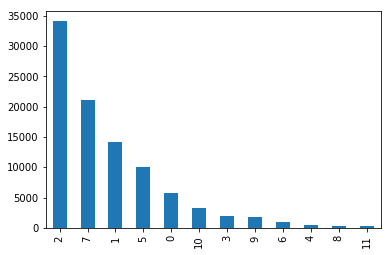

In [22]:
#预测结果后处理
y_test = lgb_model.predict_proba(test_x, num_iteration=lgb_model.best_iteration_)
pro_df = pd.DataFrame(y_test)
pro_df[1] = pro_df[1]*0.8
pro_df[7] = pro_df[7]*0.8
pro_df[3] = pro_df[3]*2
pro_df[4] = pro_df[4]*2
pro_df[6] = pro_df[6]*2
pro_df['recommend_mode'] = pro_df.apply(lambda x: np.argmax(x.values),axis=1)
pro_df['sid'] = data[test_index]['sid'].reset_index(drop=True)
pro_df['recommend_mode'].value_counts().plot(kind='bar')
pro_df['recommend_mode'].value_counts()
# pro_df.head()

In [23]:
pro_df[['sid','recommend_mode']].to_csv('submission/submission20190522_1.csv',index=None)

### 预测结果stacking

In [26]:
#后处理
pro_df = test_preDF.reset_index().groupby('index').mean()
pro_df[1] = pro_df[1]*0.8
pro_df[7] = pro_df[7]*0.8
pro_df[3] = pro_df[3]*2
pro_df[4] = pro_df[4]*2
pro_df[6] = pro_df[6]*2
pro_df['recommend_mode']  = pro_df.apply(lambda x:np.argmax(x.values),axis=1)
pro_df = pro_df.reset_index().rename(columns={'index':'sid'})
pro_df['recommend_mode'].value_counts()
# pro_df

2     90568
7     55304
1     41985
5     32992
0     32029
9     29486
10     7779
11     4626
3      4270
6      3564
4      1459
8       854
Name: recommend_mode, dtype: int64

In [30]:
result = pro_df[['sid','recommend_mode']]
result.to_csv('submission/submission20190605_1.csv',index=None)

Normalized confusion matrix
[[2.12777477e-01 2.06099982e-01 1.78668110e-01 1.10088432e-02
  2.16567407e-03 1.15141671e-01 1.24526259e-02 1.80653312e-01
  4.87276665e-03 3.75383505e-02 3.19436925e-02 6.67749504e-03]
 [2.39991273e-03 7.71026508e-01 6.23977310e-02 6.98156431e-03
  1.52721719e-03 2.42173012e-02 8.72695538e-03 8.05061634e-02
  5.99978183e-03 1.88720410e-02 1.23268245e-02 5.01799935e-03]
 [1.00699864e-04 1.54574291e-02 9.58662706e-01 0.00000000e+00
  0.00000000e+00 2.31609687e-03 2.01399728e-04 2.92029606e-03
  2.01399728e-04 1.27385328e-02 7.25039021e-03 1.51049796e-04]
 [1.20268836e-02 2.82278033e-01 1.93845065e-01 5.41209763e-02
  1.76865936e-03 8.66643085e-02 1.06119561e-02 2.43721259e-01
  1.02582243e-02 4.74000707e-02 4.49239476e-02 1.23806155e-02]
 [1.61290323e-02 3.70967742e-01 2.06451613e-01 1.35483871e-02
  1.03225806e-02 4.25806452e-02 1.03225806e-02 2.17419355e-01
  9.03225806e-03 5.22580645e-02 4.06451613e-02 1.03225806e-02]
 [2.58690380e-03 4.65642684e-02 1.196

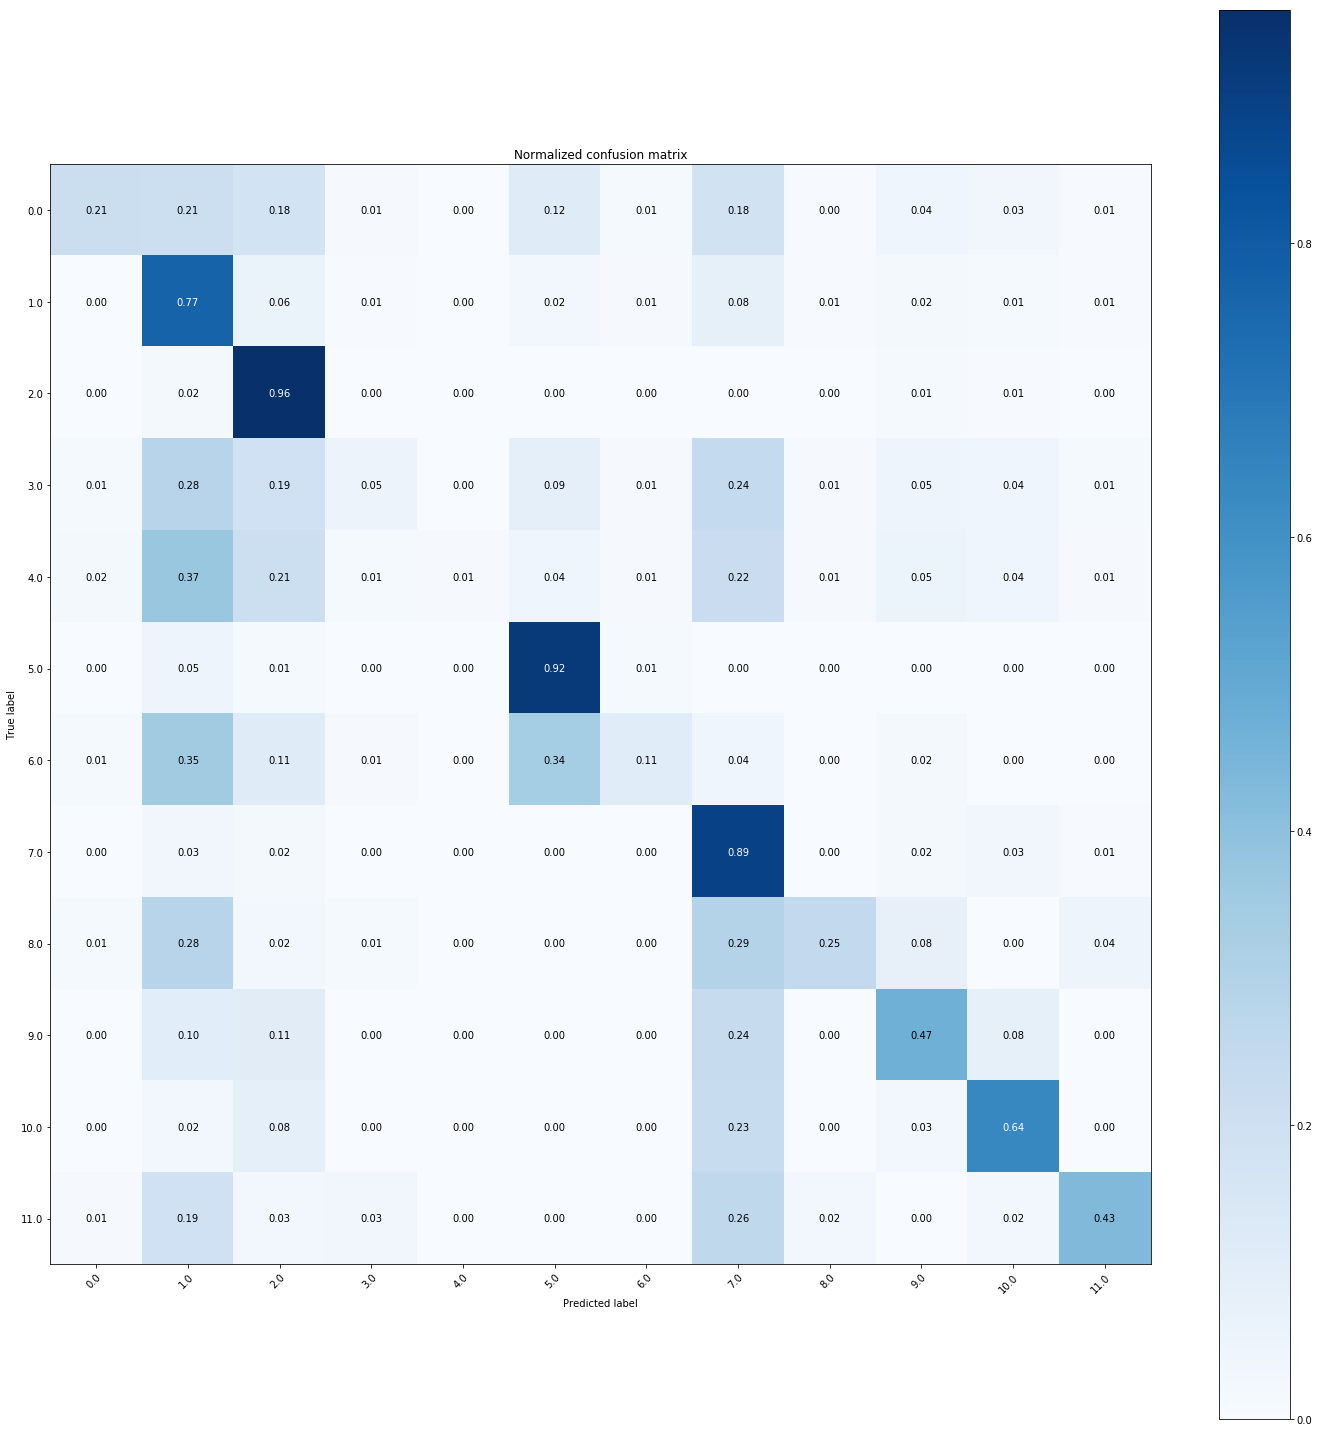

In [77]:
from functions import plot_confusion_matrix
valid_pred = lgb_model.predict(valid_x, num_iteration=lgb_model.best_iteration_)
plot_confusion_matrix(valid_y.values, valid_pred, classes_name=np.sort(valid_y.unique()), normalize=True,
                      title='Normalized confusion matrix')

In [28]:
pro_df['recommend_mode']

0         2
1         1
2         7
3         2
4         5
5         1
6         5
7         2
8         1
9         1
10        2
11        7
12        7
13        7
14        1
15        1
16        1
17        3
18        1
19        6
20        2
21        3
22        2
23        5
24        7
25        5
26        2
27        1
28        9
29        7
         ..
304886    0
304887    0
304888    5
304889    2
304890    2
304891    2
304892    2
304893    9
304894    0
304895    1
304896    5
304897    0
304898    9
304899    2
304900    0
304901    2
304902    0
304903    5
304904    9
304905    2
304906    0
304907    2
304908    2
304909    5
304910    0
304911    0
304912    0
304913    0
304914    0
304915    0
Name: recommend_mode, Length: 304916, dtype: int64

In [11]:
# sid plan_mode doc2vec
from gen_feature import gen_doc2vec_feature
tmp_df = df_plan.groupby('sid')['transport_mode'].apply(list)
tmp_df = tmp_df.reset_index()
plan_doc2vec,plan_mode_emd = gen_doc2vec_feature(tmp_df,'transport_mode',size=8)
tmp_df = pd.concat([tmp_df[['sid']],plan_doc2vec],axis=1)
tmp_df['sid'] =tmp_df['sid'].astype(int)
data = data.merge(tmp_df,'left','sid')
data.shape

doc2vec training...
doc2vec over


(594358, 121)

In [25]:
tmp = pd.DataFrame()
tmp[['sid','eta_min_mode']] = df_plan.loc[df_plan.groupby(['sid'])['eta'].idxmin()][['sid','transport_mode']].reset_index(drop=True)
tmp['eta_max_mode'] = df_plan.loc[df_plan.groupby(['sid'])['eta'].idxmax()]['transport_mode'].reset_index(drop=True)
tmp['dis_min_mode'] = df_plan.loc[df_plan.groupby(['sid'])['distance'].idxmin()]['transport_mode'].reset_index(drop=True)
tmp['dis_max_mode'] = df_plan.loc[df_plan.groupby(['sid'])['distance'].idxmax()]['transport_mode'].reset_index(drop=True)
tmp['price_min_mode'] = df_plan.loc[df_plan.groupby(['sid'])['price'].idxmin()]['transport_mode'].reset_index(drop=True)
tmp['price_max_mode'] = df_plan.loc[df_plan.groupby(['sid'])['price'].idxmax()]['transport_mode'].reset_index(drop=True)
tmp['speed_min_mode'] = df_plan.loc[df_plan.groupby(['sid'])['speed'].idxmin()]['transport_mode'].reset_index(drop=True)
tmp['speed_max_mode'] = df_plan.loc[df_plan.groupby(['sid'])['speed'].idxmax()]['transport_mode'].reset_index(drop=True)
tmp.head()

KeyError: 'Column not found: trans_port'